In [2]:
!pip install yfinance pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 46.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 3.6 MB/s eta 0:00:00
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=b80bb7185fdf9bb69406c73d6fc0eef78ac3bb4e1ed6ce2203cabb970d915793
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
  Created wheel for peewee: filename=peewee-3.17.3-cp310-cp310-linux_x86_64.whl size=293152 sha256=8a9d93067b59d2a11639ded3c6d160eb70e36af1bb451277cf10cb5764d3e226
  Stored in directory: /root/.cache/pip/wheels/0d/32/b7/cad9f818b37cf97df4c87a8308da86a433af81651d98f8d8aa
Successfully built pandas_ta peewe

In [21]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import pandas_ta as ta
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings

# Suppress the warning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import warnings

# Suppress the specific warning
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")

# Load financial data
start_date = dt.date.today() - dt.timedelta(days=365*10)  #years
end_date = dt.date.today() + dt.timedelta(days=1)

ticker = '^GSPC'
df = yf.download(ticker, start_date, end_date)

# energy sp500 sector
ticker_energy = '^GSPE'
df_e = yf.download(ticker_energy, start_date, end_date)

# vix volatibility
ticker_vol = '^VIX'
df_v = yf.download(ticker_vol, start_date, end_date)

# oil price
ticker_oil = 'CL=F'
df_oil = yf.download(ticker_oil, start_date, end_date)

# Microsoft
ticker_msft = 'MSFT'
df_msft = yf.download(ticker_msft, start_date, end_date)

# Nvidia
ticker_nvidia = 'NVDA'
df_nvidia = yf.download(ticker_nvidia, start_date, end_date)

# Broadcom
ticker_broadc = 'AVGO'
df_broadc = yf.download(ticker_broadc, start_date, end_date)

# dow jones industrial average
ticker_dow = '^DJI'
df_dow = yf.download(ticker_dow, start_date, end_date)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [22]:
print(start_date,end_date)

2014-04-30 2024-04-28


In [23]:
df_oil['Oil_Close'] = df_oil['Close'].pct_change()*100
df_e['E_Close'] = df_e['Close'].pct_change()*100
df_v['Vol_Close'] = df_v['Close'].pct_change()*100
df_msft['Msft_Close'] = df_msft['Close'].pct_change()*100
df_nvidia['Nvidia_Close'] = df_nvidia['Close'].pct_change()*100
df_broadc['Broadcom_Close'] = df_broadc['Close'].pct_change()*100
df_dow['Dow_Close'] = df_dow['Close'].pct_change()*100

In [24]:
# Adding the technical indicators
df['RSI'] = ta.rsi(df['Close'], timeperiod=14)

df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], timeperiod=14)
# Calculate stochastic oscillator
stoch_results = ta.stoch(df['High'], df['Low'], df['Close'], window=14, smooth_window=3)
df['%K'] = stoch_results['STOCHk_14_3_3']
df['%D'] = stoch_results['STOCHd_14_3_3']

# Add the MACD line to df
df_macd=df.ta.macd(fast=12, slow=26, signal=9, append=True)
# Add the MACD line to df
df['MACD'] = df_macd['MACD_12_26_9']

# Calculate On-balance volume
df['OBV']=ta.obv(df['Close'], df['Volume'])

##########
df['Open'] = df['Open'].pct_change()*100
df['High'] = df['High'].pct_change()*100
df['Low'] = df['Low'].pct_change()*100
df['Volume'] = df['Volume'].pct_change()*100

#pct %
df['PCT'] = df['Close'].pct_change()*100

# days pct %
df['PCT_7'] = df['Close'].pct_change(periods=7)*100
df['PCT_6'] = df['Close'].pct_change(periods=6)*100
df['PCT_5'] = df['Close'].pct_change(periods=5)*100
df['PCT_4'] = df['Close'].pct_change(periods=4)*100
df['PCT_3'] = df['Close'].pct_change(periods=3)*100
df['PCT_2'] = df['Close'].pct_change(periods=2)*100

df = pd.concat([df,df_e['E_Close'],df_v['Vol_Close'],df_oil['Oil_Close'],df_msft['Msft_Close'],
                df_nvidia['Nvidia_Close'],df_broadc['Broadcom_Close'], df_dow['Dow_Close']], axis=1)

In [25]:
df = df.dropna()

# Extract features and signal features
#features = ['Open', 'High','Low', 'Volume', 'RSI','ATR','%K','%D','MACD_12_26_9','MACD','OBV']
#features = ['Open', 'High','Low', 'Volume', 'RSI', 'PCT']
#features = ['Open', 'High','Low', 'Volume', 'RSI','PCT','E_Close','Vol_Close','Oil_Close','Dolar_Close']
#features = ['Open', 'High','Low', 'Volume', 'RSI','PCT', 'E_Close','Vol_Close','Oil_Close', 'ATR','%K','%D']
features = ['Open', 'High','Low', 'Volume', 'RSI','E_Close','Vol_Close','Oil_Close', 'ATR','%K','%D','MACD','Dow_Close',
            'PCT_7','PCT_6','PCT_5','PCT_4','PCT_3','PCT_3']
x = df[features]
y = df['PCT']

In [26]:
x

,Open,High,Low,Volume,RSI,E_Close,Vol_Close,Oil_Close,ATR,%K,%D,MACD,Dow_Close,PCT_7,PCT_6,PCT_5,PCT_4,PCT_3,PCT_3
Date,,,,,,,,,,,,,,,,,,,
2014-06-17,0.119393,0.130846,0.136724,1.542310,64.745999,-0.169780,-4.664025,-0.505146,11.430393,65.767554,65.517922,17.458707,0.163759,-0.382159,-0.475589,-0.451102,-0.097743,0.615509,0.615509
2014-06-18,0.288050,0.722854,0.296863,3.162295,70.651496,0.754171,-12.023223,-0.366679,11.975678,77.232876,68.341742,17.970604,0.583806,0.292628,0.317304,0.673390,1.392148,1.075322,1.075322
2014-06-19,0.760271,0.108799,0.668800,-3.688805,71.508699,0.619852,0.094253,0.434084,11.638655,89.213022,77.404484,18.366300,0.087787,0.445458,0.801998,1.521675,1.204443,1.119836,1.119836
2014-06-20,0.150700,0.206138,0.353951,46.884135,72.674210,0.952930,2.165730,0.779857,11.109146,98.332018,88.259305,18.737444,0.151400,0.976392,1.697313,1.379533,1.294779,1.075186,1.075186
2014-06-23,0.125996,-0.008658,-0.014293,-37.327500,72.429477,0.399103,1.198149,-1.016226,10.631267,97.982257,95.175766,18.793953,-0.057947,1.683842,1.366104,1.281361,1.061797,0.287688,0.287688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-22,-0.361804,0.394894,0.319767,-1.508218,37.897454,0.636372,-9.460174,-0.348810,59.238710,8.952138,6.130309,-35.113118,0.667560,-3.624885,-2.201855,-1.011884,-0.807894,-0.231170,-0.231170
2024-04-23,0.832510,0.739858,1.178413,-1.802238,45.672800,0.525592,-7.378990,0.615573,59.687375,20.647003,11.404225,-33.007959,0.689621,-1.031742,0.172467,0.378897,0.962521,1.185956,1.185956
2024-04-24,1.113769,0.263190,0.379081,-2.523325,45.804452,0.103480,1.784581,-0.659793,58.456845,33.652658,21.083933,-30.896300,-0.111079,0.193805,0.400279,0.984027,1.207510,2.101773,2.101773


In [27]:
y

Date
2014-06-17    0.217257
2014-06-18    0.771888
2014-06-19    0.127748
2014-06-20    0.173006
2014-06-23   -0.013246
                ...   
2024-04-22    0.873125
2024-04-23    1.196458
2024-04-24    0.021301
2024-04-25   -0.457643
2024-04-26    1.020914
Name: PCT, Length: 2481, dtype: float64

In [28]:
#SCALING THE DATA
scaler = MinMaxScaler(feature_range=(0,1))

x_train = x.reset_index(drop=True)
y_train = y.reset_index(drop=True)

x_train = scaler.fit_transform(x_train)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

y_train = y_train.values.reshape(y_train.shape[0],1)
y_train = scaler.fit_transform(y_train)

print (x_train.shape, y_train.shape)


(2481, 19, 1) (2481, 1)


In [29]:
print(np.min(x_train), np.max(x_train))
print(np.min(y_train), np.max(y_train))

0.0 1.0
0.0 0.9999999999999998


In [30]:
# BIDIRECTIONAL MODEL
from keras import layers, Input
from keras.layers import BatchNormalization

model = tf.keras.models.Sequential([
layers.Conv1D(32, 1, input_shape=(x_train.shape[1], 1), padding="same", activation="swish"),
layers.Conv1D(32, 1, padding="same", activation="swish"),
layers.Conv1D(64, 1, padding="same", activation="swish"),
layers.Conv1D(64, 1, padding="same", activation="swish"),
    
#layers.Bidirectional(LSTM(units=125,return_sequences=True,input_shape=(x_train.shape[1], 1), activation="swish")),
layers.Bidirectional(LSTM(units=125,return_sequences=True, activation="swish")),
layers.Dropout(0.3),
layers.Bidirectional(LSTM(units=125,return_sequences=True, activation="swish")),
layers.Dropout(0.3),
layers.Flatten(),
layers.Dense(128, activation='swish'),
layers.Dense(32, activation='swish'),
layers.Dense(1, activation="linear")
])

model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 19, 32)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 19, 32)         │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 19, 64)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 19, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 19, 250)        │       190,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 19, 250)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 19, 250)        │       376,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 19, 250)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4750)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       608,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,185,681 (4.52 MB)

 Trainable params: 1,185,681 (4.52 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

In [32]:
### OTHER SPLIT DATA MODEL

from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam, Lion, LossScaleOptimizer
from sklearn.model_selection import train_test_split
from keras.optimizers.schedules import ExponentialDecay

#x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=8, min_lr=1e-8)

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.2)

model.compile(#optimizer=Adam(learning_rate=1e-3),
              #optimizer=Lion(learning_rate=1e-4, weight_decay=True),
              optimizer=LossScaleOptimizer(Lion(learning_rate=1e-4, weight_decay=True), initial_scale=32768.0, dynamic_growth_steps=1000),
              loss='mse',
              metrics=["r2_score"])
hist = model.fit(x_train,y_train,
          epochs=70,
          batch_size=32,
          #verbose=1,
          #callbacks=[reduce_lr],
          validation_split=0.2,
          #validation_data=[x_test, y_test]
         )


Epoch 1/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/step - loss: 0.2800 - r2_score: -100.5682 - val_loss: 0.0273 - val_r2_score: -6.6119
Epoch 2/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0169 - r2_score: -4.1849 - val_loss: 0.0035 - val_r2_score: 0.0345
Epoch 3/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0025 - r2_score: -0.0059 - val_loss: 0.0036 - val_r2_score: 0.0020
Epoch 4/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0036 - r2_score: -0.0109 - val_loss: 0.0036 - val_r2_score: -0.0026
Epoch 5/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0030 - r2_score: -0.0100 - val_loss: 0.0036 - val_r2_score: -0.0114
Epoch 6/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0026 - r2_score: -0.0133 - val_loss: 0.0036 - val_r2_score: -0.0033
Epoch 7/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0021 - r2_score: -0.0248 - val_loss: 0.0038 - val_r2_score: -0.0454
Epoch 8/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0026 - r2_score: -0.0341 - val_los

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
(249, 1) (249, 1)
MAPE: 1.1672470105250004
Mean squared error: 0.0642053744547748
Root mean squared error: 0.25338779460497857
Mean absolute error: 0.19320884306330494
R2: 0.8801382291560029


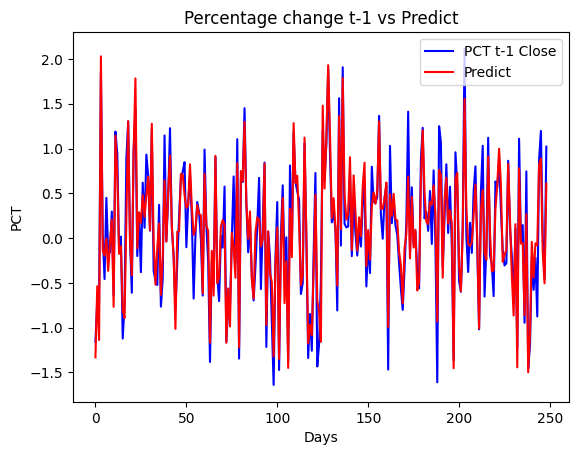

In [35]:
# VALUE VS PREDICTION ONLY WITH TEST DATA

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
# value vs prediction

predicted_stock = model.predict(x_test)
predicted_stock = scaler.inverse_transform(predicted_stock)

sp500_close = scaler.inverse_transform(y_test)

print (predicted_stock.shape, sp500_close.shape)
mape = mean_absolute_percentage_error(sp500_close, predicted_stock)
mse = mean_squared_error(sp500_close, predicted_stock)
rmse = mean_squared_error(sp500_close, predicted_stock, squared=False)
mae = mean_absolute_error(sp500_close, predicted_stock)
r2 = r2_score(sp500_close, predicted_stock)
print("MAPE:", mape)
print("Mean squared error:", mse)
print("Root mean squared error:", rmse)
print("Mean absolute error:", mae)
print("R2:", r2)


plt.plot(sp500_close, color = 'blue', label = 'PCT t-1 Close')
plt.plot(predicted_stock, color = 'red', label = 'Predict')
plt.title('Percentage change t-1 vs Predict')
plt.xlabel('Days')
plt.ylabel('PCT')
plt.legend()
plt.show()